In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
import seaborn as sns


In [3]:
df=pd.read_csv('/Users/jonathanmichelin/Desktop/python/project/final_model_input_data.csv')
df.fillna(0, inplace=True)
df.columns

Index(['Unnamed: 0', 'creative_more', 'assertive_more', 'imaginative_more',
       'calm_more', 'careless_more', 'broad_minded_more', 'sympathetic_more',
       'willpower_more', 'change_for_better_more', 'lower_expectations_more',
       'avoid_disappointments_low_goals_more', 'learn_from_difficulties_more',
       'relieved_less_responsibilities_more', 'get_things_done_more',
       'new_perspective_more', 'problem_solving_more',
       'persevere_tough_times_more', 'chg_phy_health', 'chg_ment_health',
       'chg_life_sat', 'chg_post_relt', 'chg_autonomy', 'chg_env_mast',
       'chg_pers_grwt', 'is_white', 'is_black', 'is_native', 'is_asian',
       'agency_chg', 'age_2019', 'female_annual_income', 'male_annual_income',
       'entrepreneur', 'became_entrepreneur', 'is_not_entrepreneur',
       'remained_entrepreneur', 'grat_born', 'grat_alive', 'grat_to_people',
       'is_entrepreneur'],
      dtype='object')

In [6]:
df['life_satisfaction_more']=np.where(df.chg_life_sat>0,1,0)

In [8]:
# Features (excluding all entrepreneur-related fields except is_entrepreneur)
X = df.drop(columns=[
    'life_satisfaction_more',
    'chg_life_sat',
    #'is_entrepreneur',
    'became_entrepreneur', 
    'is_not_entrepreneur', 
    'remained_entrepreneur',
    'grat_born',
    'grat_to_people',
    'entrepreneur'
])

# Target variable
y = df['life_satisfaction_more']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print the results

conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Calculate percentage change in is_entrepreneur
coef = model.coef_[0]
feature_names = X.columns

df_model_output=pd.DataFrame

# Displaying the coefficients (change in is_entrepreneur per feature)
print("\nPercentage change in is_entrepreneur for each feature:")
for name, coefficient in zip(feature_names, coef):
    print(f"{name}: {coefficient:.4f}")

Accuracy: 70.92%
Recall: 0.45
F1-Score: 0.53
ROC-AUC Score: 0.7505
Confusion Matrix:
[[815 141]
 [292 241]]

Percentage change in is_entrepreneur for each feature:
Unnamed: 0: 0.0426
creative_more: 0.0821
assertive_more: 0.0730
imaginative_more: 0.0656
calm_more: 0.0320
careless_more: 0.0461
broad_minded_more: 0.0755
sympathetic_more: 0.0782
willpower_more: 0.0339
change_for_better_more: 0.1098
lower_expectations_more: 0.0327
avoid_disappointments_low_goals_more: 0.0450
learn_from_difficulties_more: 0.0482
relieved_less_responsibilities_more: 0.1240
get_things_done_more: 0.1427
new_perspective_more: 0.0542
problem_solving_more: 0.0509
persevere_tough_times_more: 0.0355
chg_phy_health: 0.0902
chg_ment_health: -0.0231
chg_post_relt: 0.1543
chg_autonomy: -0.0258
chg_env_mast: 0.3461
chg_pers_grwt: -0.0634
is_white: 0.3931
is_black: 0.0683
is_native: 0.0417
is_asian: 0.0901
agency_chg: 0.7688
age_2019: 0.0745
female_annual_income: 0.1338
male_annual_income: -0.0912
grat_alive: 0.0892
is_en

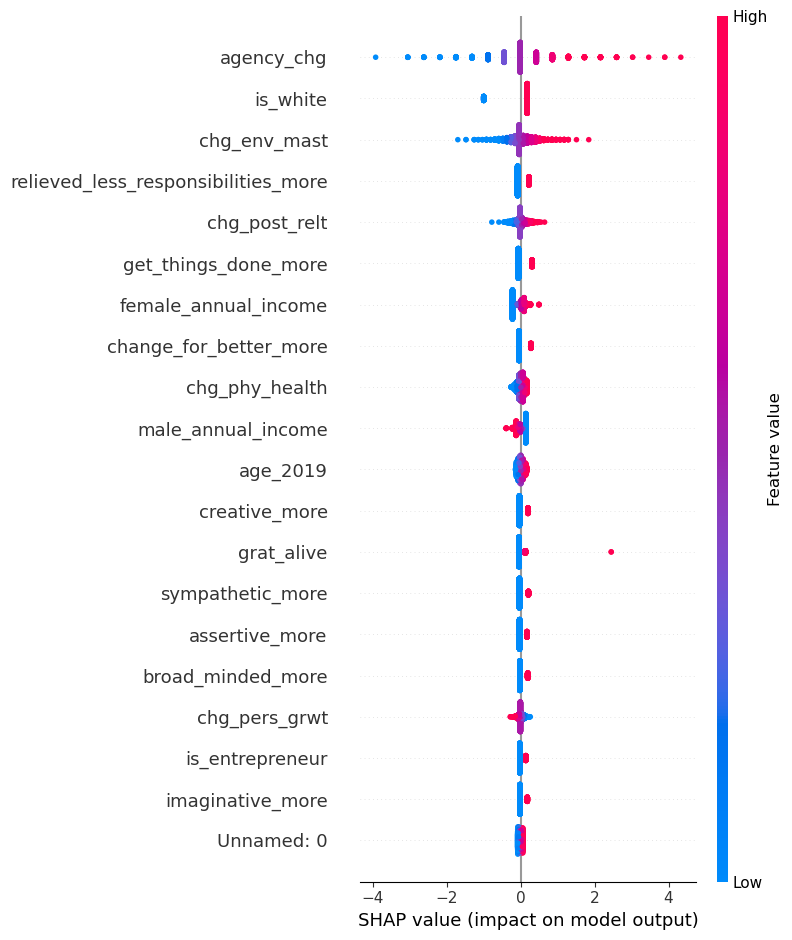

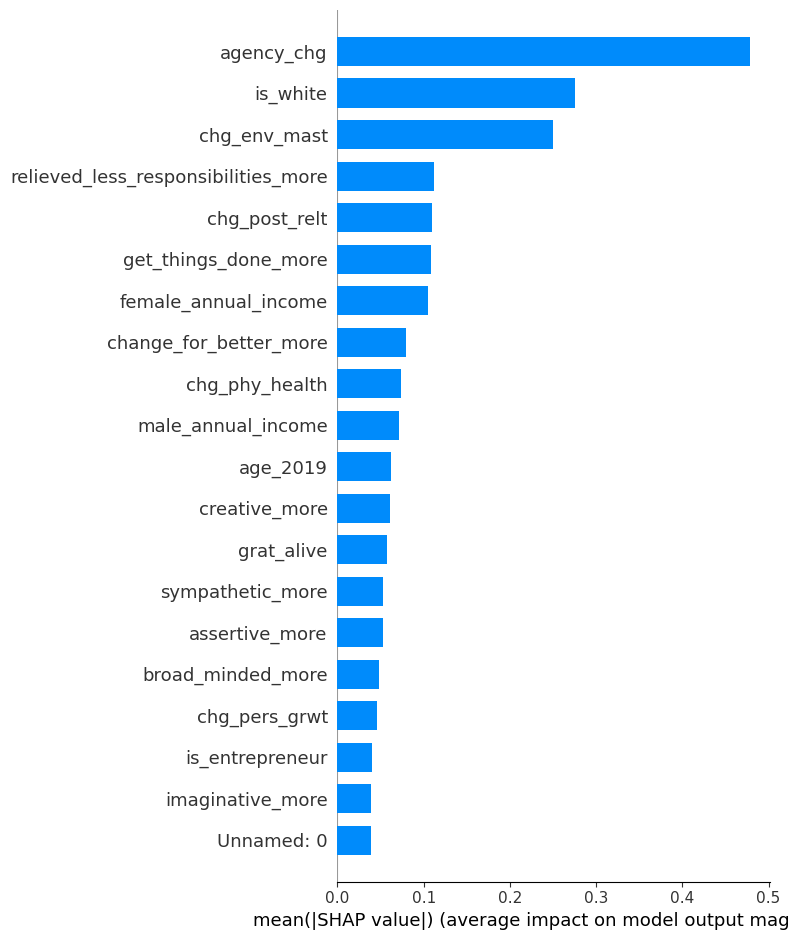

In [10]:
# get shapley values
import shap
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

#visualize shap values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

instance_index = 0  # Change this to analyze different samples
shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test[instance_index], feature_names=X.columns)

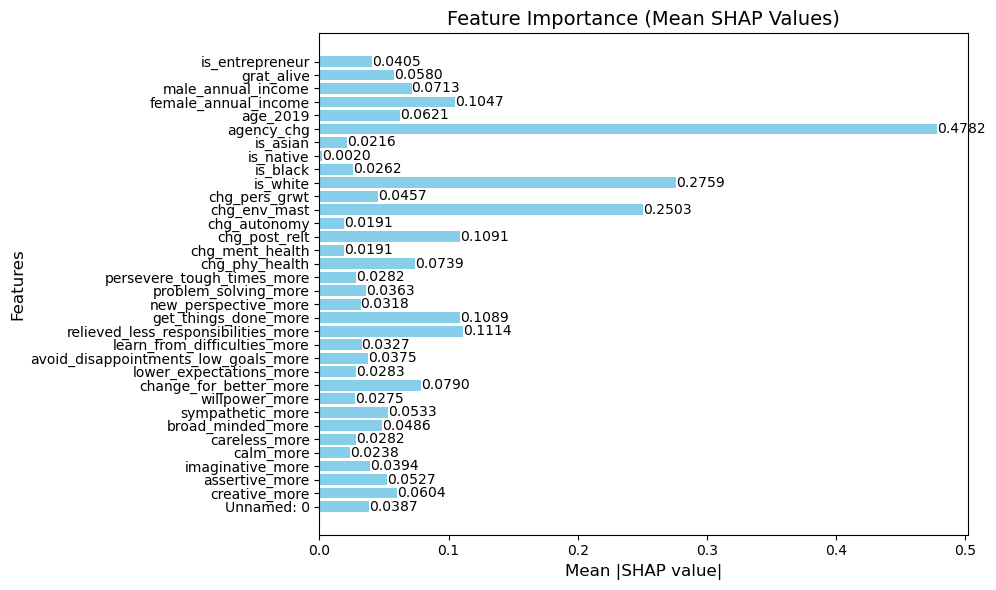

In [11]:
import matplotlib.pyplot as plt
import shap

# Generate SHAP values
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
shap_values_mean = np.abs(shap_values).mean(axis=0)

# Plot a bar chart with annotations
plt.figure(figsize=(10, 6))
bar = plt.barh(X.columns, shap_values_mean, color="skyblue")

# Annotate the bars
for rect in bar:
    plt.text(rect.get_width(), rect.get_y() + rect.get_height() / 2,
             f"{rect.get_width():.4f}", ha="left", va="center")

plt.xlabel("Mean |SHAP value|", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance (Mean SHAP Values)", fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
import statsmodels.api as sm

# Add a constant to the features
X_train_const = sm.add_constant(X_train)

# Fit the model
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Assign actual feature names, including the constant term
feature_names = ['Intercept'] + list(X.columns)

# Print the summary with feature names
print(result.summary(xname=feature_names))

Optimization terminated successfully.
         Current function value: 0.538742
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     life_satisfaction_more   No. Observations:                 3474
Model:                              Logit   Df Residuals:                     3439
Method:                               MLE   Df Model:                           34
Date:                    Thu, 23 Jan 2025   Pseudo R-squ.:                  0.1717
Time:                            14:48:22   Log-Likelihood:                -1871.6
converged:                           True   LL-Null:                       -2259.6
Covariance Type:                nonrobust   LLR p-value:                3.940e-141
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept               

In [13]:
summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + list(X.columns),
    'Coefficient': result.params.values,
    'Std Error': result.bse.values,
    'Z-Value': result.tvalues.values,
    'P-Value': result.pvalues.values,
    'Conf Lower': result.conf_int()[0].values,
    'Conf Upper': result.conf_int()[1].values,
    'Significant': result.pvalues.values < 0.05
})
summary_table
summary_table.to_csv('/Users/jonathanmichelin/Desktop/python/project/logistic_regression_summary.csv', index=False)

In [21]:
sns.pairplot(df)

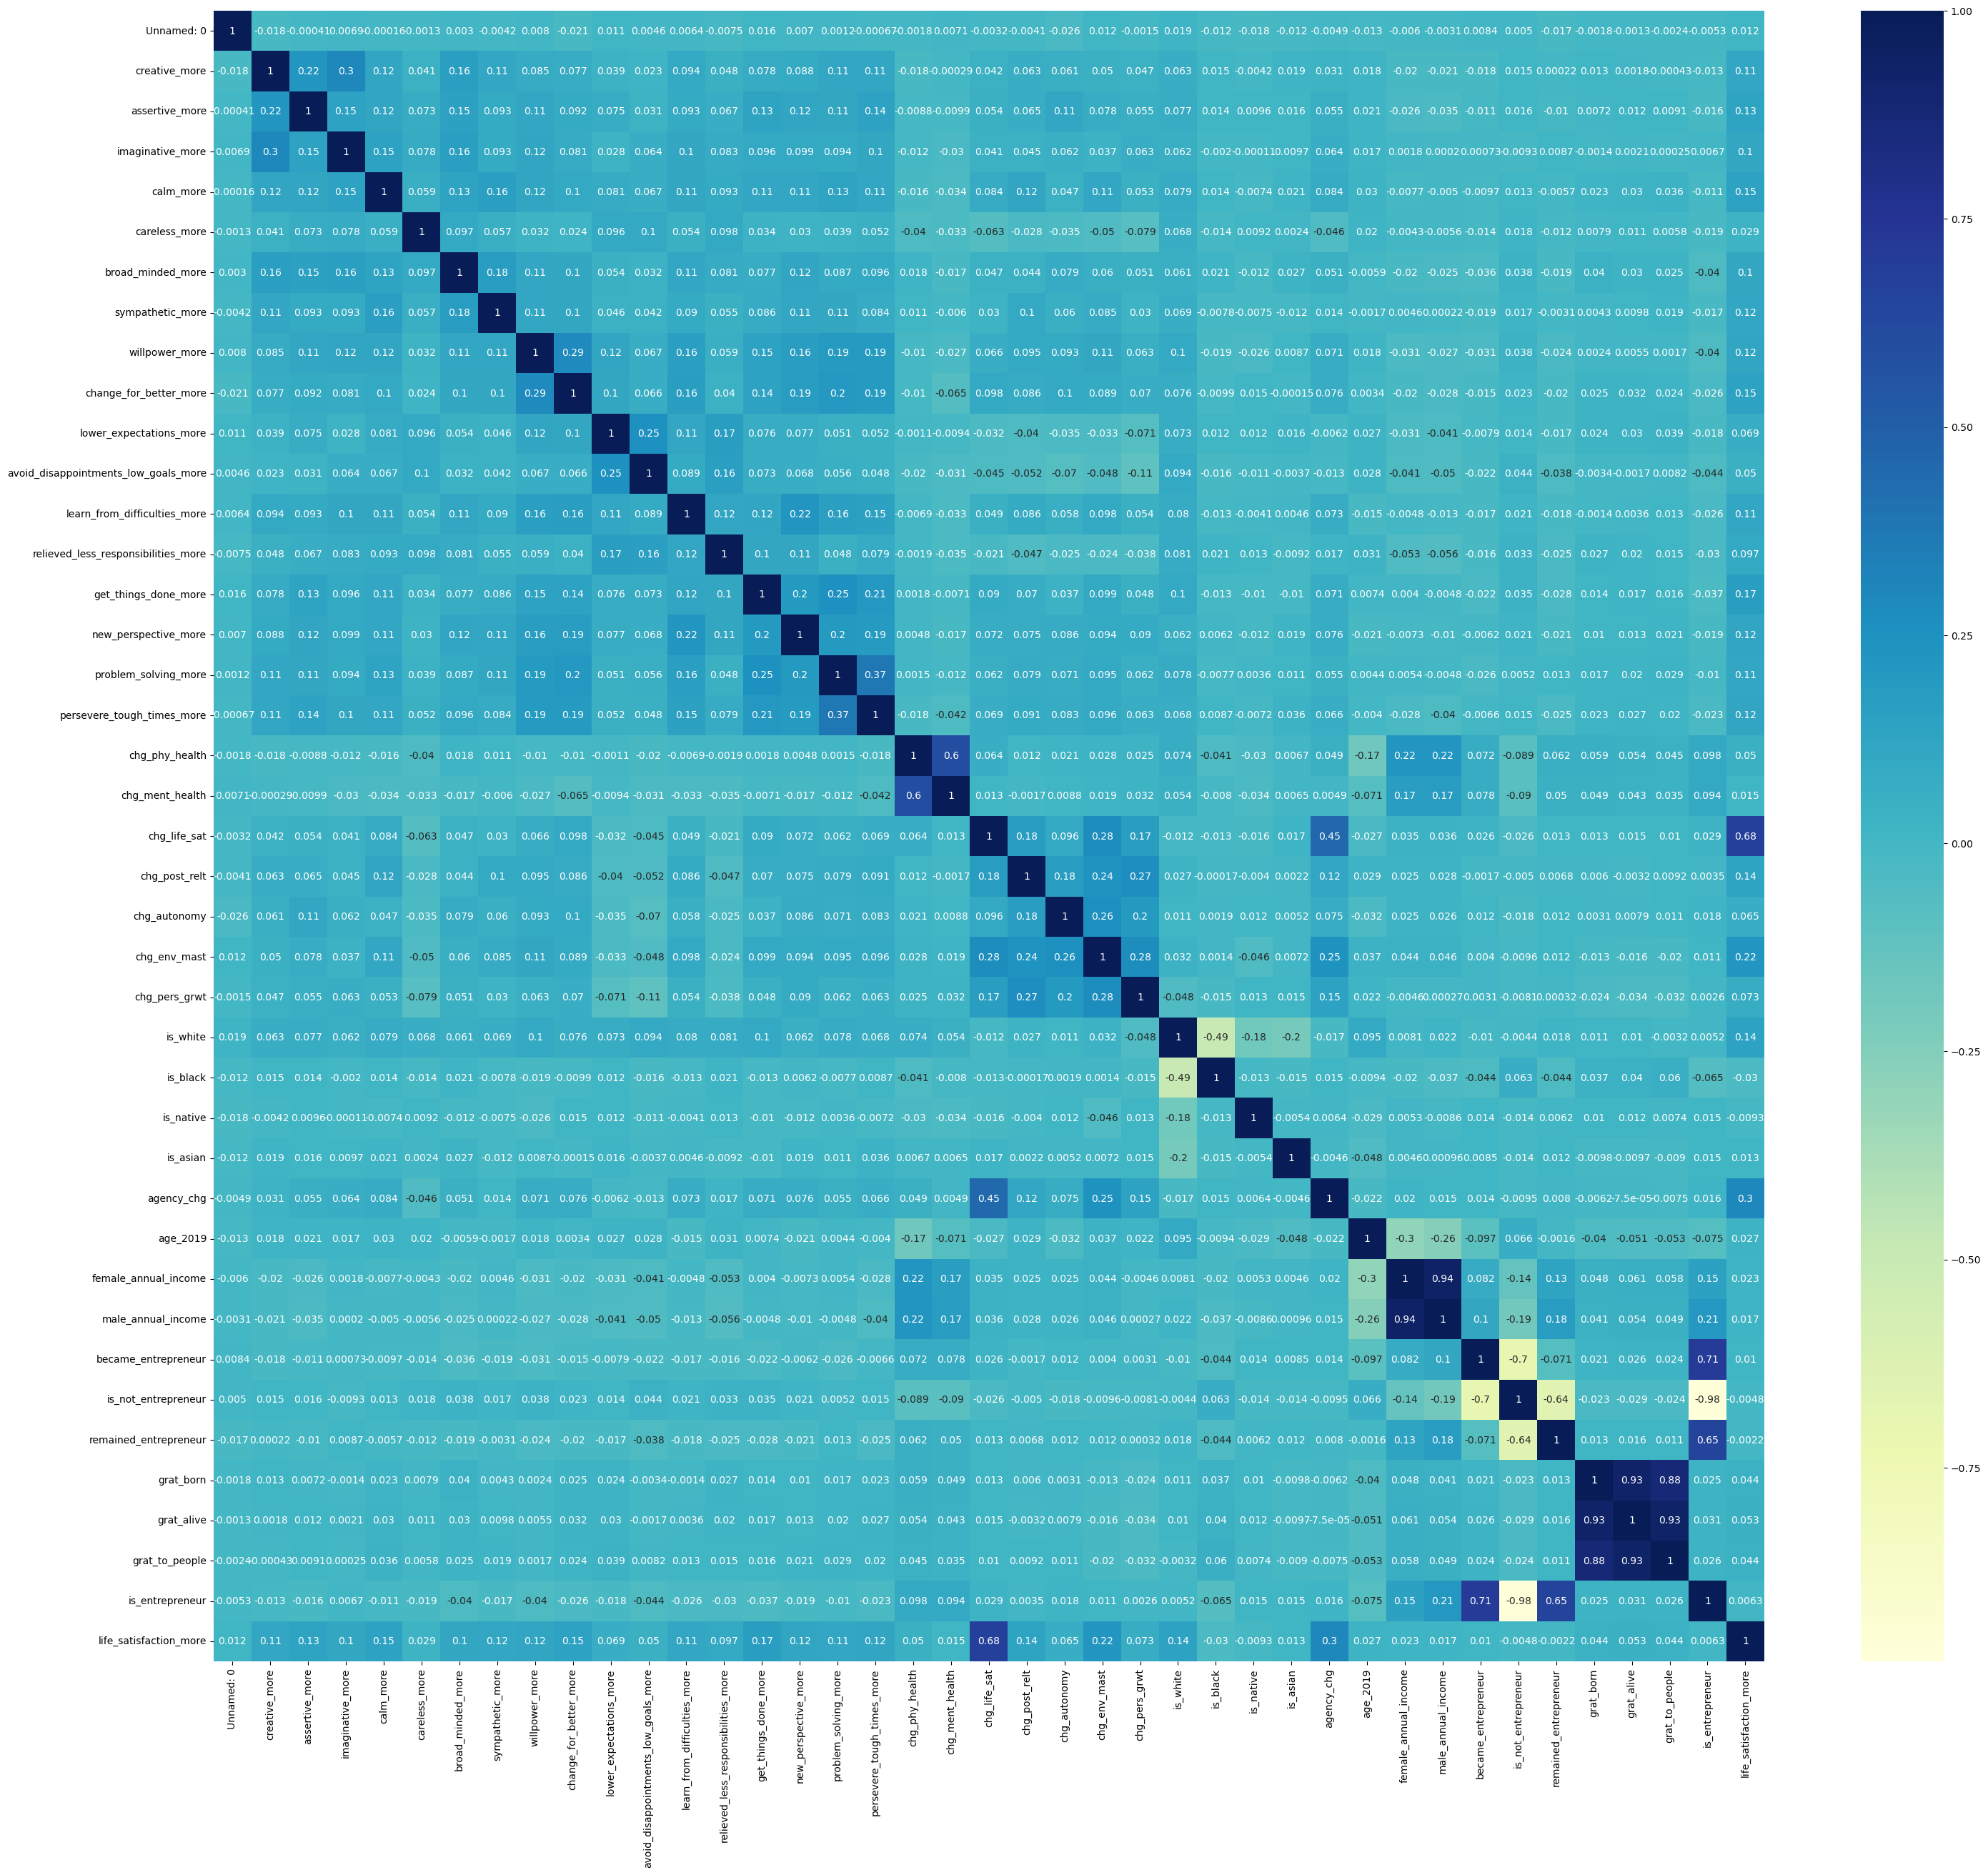

In [31]:
fig, ax = plt.subplots(figsize=(35, 30))  # Set the figure size
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)